In [20]:
# use the environment of py-gplate
import sys
import gplately
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cartopy.crs as ccrs
from plate_model_manager import PlateModelManager
import math
import re

# directory to the aspect Lab
# set the location of file outputs
ASPECT_LAB_DIR = os.environ['ASPECT_LAB_DIR']
base_dir = ASPECT_LAB_DIR
RESULT_DIR = os.path.join(base_dir, 'results')
Utilities_dir = os.path.join(base_dir, 'utilities', "python_scripts")
if not os.path.isdir(Utilities_dir):
    raise FileNotFoundError("The utilities Doesn't exist yet")
# import shilofue.GPlateLib as GPlateLib
# import utilities in subdirectiory
sys.path.append(Utilities_dir)
import Utilities


### Workflow for Subduction Dataset from Plate Reconstruction

#### Pre-requisites

- Download the utilities file at (TODO: package this file)

    https://github.com/lhy11009/Utilities/blob/master/python_scripts/Utilities.py

and put it into a directory called

    "utilities"

- Install the gplately package (TODO: include a conda file)

- One must first use gplate and export a "reconstruction" file for the specific timestep. This file serves to look up names and ids of the subduction zones.

#### General workflow

This workflow defines the steps to query a subduction plate dataset based on plate reconstruction data.

To get a good dataset for a time step:

1. **Select the Automatic Workflow and get a global dataset**:
   - Use the global dataset with the automatic workflow to initiate the data processing. This is a good reference dataset to refine points of respective trenches.


2. **Look in the global dataset for a local subset or extract a Local dataset directly**:
    - To directly extract a local dataset, look for a id for a trench. Put that in the workflow to extract a single trench.
    - When we are satisfied, damp the data in to a finalized dataset.

3. **Resample the subduction zones**"
    - To discretinize the subduction zones with the appropriate interval (e.g. 200 km), an option to rample them is included in the notebook.

3. **Analyze the Finalzed Dataset** 


#### Some Notes

##### Fixing Subducting Plate Age
To accurately determine the age of the subducting plate, we must ensure that the points are correctly pinned to the subducting plate. This involves two workflows:

**Automatic Workflow**: By calling the fill_NaNs value in the age raster. This will automatic fill-in the invalid vlaues

    age_grid_raster.fill_NaNs(inplace=True)

##### Trench pid and subduction pid

The **trench PID** and **subduction PID** correspond to the IDs used in the plate reconstruction process (TODO: look carefully in their paper).

- **Subduction PID**: The process ID (PID) for the subduction zone, as used in the reconstruction.
- **Trench PID**: The process ID (PID) for the trench, as used in the reconstruction.

#### Utility functions

- **mask_by_pids**: Generates a mask based on proximity to specified subducting and trench process IDs.
- **haversine**: Calculates the great-circle distance between two geographical points on Earth using the Haversine formula.
- **ReadFile**: Reads a file of plate reconstruction data to extract subduction zone details, including locations and IDs.
- **LookupNameByPid**: Finds the name of a trench given its corresponding plate ID.
- **get_one_subduction_by_trench_id**: Retrieves data for a specific subduction zone from a global dataset based on trench ID.
- **plot_global_basics**: Plots basic global geological features on a map, including coastlines and geological age grids.
- **resample_subduction**: Resamples subduction zone data along its arc length at specified intervals for simplified analysis.
- **ResampleAllSubduction**: Resamples all subduction zones in a dataset using specified trench plate IDs.
- **ResampleSubductionById**: Resamples data for a specific subduction zone based on its trench plate ID.
- **FixTrenchAgeLocal**: Interpolates and fixes missing age values in subduction data using nearby points.
- **FixTrenchAge**: Fixes invalid trench age values in subduction data using various age interpolation methods.
- **MaskBySubductionTrenchIds**: Creates a mask for subduction data based on specified subducting and trench IDs or user-selected indices.


In [21]:
def mask_by_pids(subduction_data, subducting_pid_p, trench_pid_p=None):
    """
    Generates a mask based on proximity to subducting and trench process IDs.
    
    Parameters:
        subduction_data (object): Object containing subducting_pid and trench_pid attributes.
        subducting_pid_p (float): Target value for the subducting process ID to match.
        trench_pid_p (float, optional): Target value for the trench process ID to match.
        
    Returns:
        mask (bool array): Boolean array where True values indicate proximity to specified process IDs.
    """
    
    # Create initial mask based on subducting process ID within a tolerance of 0.1.
    mask1 = (abs(subduction_data.subducting_pid - subducting_pid_p) < 0.1)
    
    # If trench process ID is specified, create an additional mask based on its proximity.
    if trench_pid_p is not None:
        mask2 = (abs(subduction_data.trench_pid - trench_pid_p) < 0.1)
    
    # Combine masks using logical AND operation.
    mask = mask1 & mask2

    return mask


def haversine(lat1, lon1, lat2, lon2, radius=6371e3):
    """
    Calculates the great-circle distance between two points on the Earth using the Haversine formula.
    
    Parameters:
        lat1 (float): Latitude of the first point in degrees.
        lon1 (float): Longitude of the first point in degrees.
        lat2 (float): Latitude of the second point in degrees.
        lon2 (float): Longitude of the second point in degrees.
        radius (float, optional): Radius of the sphere; default is Earth's radius in meters (6371e3).
        
    Returns:
        distance (float): The distance between the two points in the specified radius unit.
    """
    
    # Convert latitude and longitude values from degrees to radians for calculation.
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    
    # Apply the Haversine formula to calculate the angular distance between points.
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    
    # Calculate the physical distance by scaling the angular distance by the specified radius.
    distance = radius * c
    return distance


def ReadFile(infile):
    """
    Reads a file of plate reconstruction data and extracts subduction zone information.
    
    Parameters:
        infile (str): The file path to the input data file.
    
    Returns:
        dict: A dictionary containing the following keys:
            - 'n_trench' (int): The number of subduction zones found in the file.
            - 'trench_data' (list): A list of arrays containing coordinates for each subduction zone.
            - 'trench_names' (list): A list of names for each subduction zone.
            - 'trench_pids' (list): A list of plate IDs associated with each subduction zone.
            - 'trench_begin_times' (list): A list of the beginning times for each subduction zone.
            - 'trench_end_times' (list): A list of the end times for each subduction zone.
    
    Implementation:
        - Opens the input file and iterates through each line.
        - Uses flags `sbd_begin` and `sbd_end` to track whether the current section is a subduction zone.
        - Extracts coordinates and header information, such as trench names, plate IDs, and time intervals.
        - Appends the extracted data into respective lists and returns them in a dictionary.
    """
    infile = os.path.join(ASPECT_LAB_DIR, "dtemp", "gplate_export_test0", 
                          "Muller_etal_2019_PlateBoundaries_no_topologies", 
                          "reconstructed_0.00Ma.xy")
    assert(os.path.isfile(infile))

    trench_data = []
    trench_names = []
    trench_pids = []
    trench_begin_times = []
    trench_end_times = []

    i = 0
    temp_l = []  # Stores line indices of each subduction zone section
    temp_d = []  # Temporarily holds coordinates of the current subduction zone
    n_trench = 0  # Counts the number of subduction zones
    sbd_begin = False  # Flag indicating the start of a subduction zone section
    sbd_end = False  # Flag indicating the end of a subduction zone section
    read = True  # Flag for continuing to read the file

    with open(infile, 'r') as fin:
        line = fin.readline()
        i += 1
        while line:
            read = True  # Default to continue reading each loop
            
            # Check if the end of a subduction zone section is reached
            if sbd_begin and re.match('^>', line):
                sbd_end = True

            # Handle the different scenarios based on the flags
            if sbd_begin and (not sbd_end):
                # Reading subduction zone data
                temp_data = line.split()
                temp_data = [float(x) for x in temp_data]
                temp_d.append(temp_data)
            elif sbd_begin and sbd_end:
                # Reached the end of a section, store the data and reset flags
                trench_data.append(temp_d)
                sbd_begin = False
                sbd_end = False
                read = False
            elif re.match('^>SubductionZone', line):
                # Found the start of a new subduction zone section
                temp_l.append(i)
                sbd_begin = True
                temp_d = []
                # Continue reading the headers of the section
                while line and re.match('^>', line):
                    line = fin.readline()
                    i += 1
                    if re.match('^> name', line):
                        trench_names.append(Utilities.remove_substrings(line, ["> name ", '\n']))
                    elif re.match('> reconstructionPlateId', line):
                        trench_pids.append(int(Utilities.remove_substrings(line, ["> reconstructionPlateId ", '\n'])))
                    elif re.match('> validTime TimePeriod <begin> TimeInstant <timePosition>', line):
                        temp0 = Utilities.remove_substrings(line, ["> validTime TimePeriod <begin> TimeInstant <timePosition>", '</timePosition>.*\n'])
                        trench_begin_times.append(float(temp0))
                        temp1 = Utilities.remove_substrings(line, ['^.*<end> TimeInstant <timePosition>', '</timePosition>.*\n'])
                        trench_end_times.append(float(temp1) if type(temp1) == float else 0.0)
                read = False
            
            if read:
                line = fin.readline()
                i += 1

    i -= 1  # Adjust for the last unsuccessful read
    n_trench = len(trench_data)

    outputs = {
        "n_trench": n_trench, 
        "trench_data": trench_data, 
        "trench_names": trench_names,
        "trench_pids": trench_pids, 
        "trench_begin_times": trench_begin_times, 
        "trench_end_times": trench_end_times
    }

    return outputs


def LookupNameByPid(trench_pids, trench_names, pid):
    """
    Looks up the name of a trench using its plate ID.

    Parameters:
        trench_pids (list): A list of plate IDs corresponding to subduction zones.
        trench_names (list): A list of names corresponding to the trench IDs.
        pid (int): The plate ID for which the trench name is being looked up.

    Returns:
        str: The name of the trench corresponding to the given plate ID. Returns an empty
             string if the plate ID is not found.
    
    Implementation:
        - Asserts that the `pid` provided is of type `int`.
        - Attempts to find the index of `pid` in the `trench_pids` list.
        - If the `pid` is found, retrieves the name from `trench_names` using the index.
        - If the `pid` is not found (raises a `ValueError`), returns an empty string.
    """
    _name = ""
    assert(type(pid) == int)
    try:
        _index = trench_pids.index(pid)
    except ValueError:
        _name = ""
    else:
        _name = trench_names[_index]
    return _name


def get_one_subduction_by_trench_id(subduction_data, trench_pid, all_columns):
    """
    Extracts data for a specific subduction zone from the global dataset at a given reconstruction time.

    Parameters:
        subduction_data (list): The global dataset of subduction zones at a particular reconstruction time.
                                Each element in this list represents a subduction zone and contains values
                                corresponding to columns in `all_columns`.
        trench_pid (int): The ID of the specific subduction zone to extract.
        all_columns (list): The list of column names for the final DataFrame, containing 10 entries:
                            ['lon', 'lat', 'conv_rate', 'conv_angle', 'trench_velocity', 
                             'trench_velocity_angle', 'arc_length', 'trench_azimuth_angle',
                             'subducting_pid', 'trench_pid'].

    Returns:
        pd.DataFrame: A pandas DataFrame containing the data for the specified subduction zone, 
                      sorted by latitude (column index 1).
    
    Implementation:
        - Initializes an empty list `ret` to store the selected subduction data.
        - Iterates over `subduction_data` and appends rows that match the `trench_pid` at index 9.
        - Sorts the collected rows by latitude (index 1) to order them spatially.
        - Converts the sorted list into a pandas DataFrame using `all_columns` as headers.
        - Returns the resulting DataFrame.
    """
    ret = []
    Found = False
    for row in subduction_data:
        if row[9] == trench_pid:  # Only select rows where the trench ID matches
            ret.append(row)
            Found = True

    # Assert the the given pid is contained in the subduction_data
    assert(Found)
    
    # Sort the selected data by latitude (index 1)
    ret.sort(key=lambda row: row[1])
    
    # Create a DataFrame with the selected and sorted data
    one_subduction_data = pd.DataFrame(ret, columns=all_columns)
    
    return one_subduction_data


def plot_global_basics(ax, gplot, age_grid_raster, reconstruction_time):
    """
    Plots basic global geological features on a given axis, including coastlines and an age grid.

    Parameters:
        ax (matplotlib.axes._axes.Axes): The axis on which to plot the global features.
        gplot (gplately.plot.PlotTopologies): An object used for plotting geological features such as coastlines.
        age_grid_raster: A raster object containing age data, typically used for visualizing geological ages.
        reconstruction_time (float): The geological time at which the reconstruction is plotted.
    
    Implementation:
        - Configures global gridlines on the plot with specific color, linestyle, and locations.
        - Sets the map extent to global.
        - Uses the `gplot` object to plot coastlines at the given reconstruction time.
        - Plots the age grid data on the map using a specified colormap and transparency level.
        - Adds a color bar to the plot to represent ages, with a labeled color bar axis.
    """
    # Configure global gridlines with specified color and linestyle
    gl = ax.gridlines(color='0.7', linestyle='--', xlocs=np.arange(-180, 180, 15), ylocs=np.arange(-90, 90, 15))
    gl.left_labels = True

    # Set the map extent to global
    ax.set_global()

    # Set the reconstruction time for the gplot object and plot coastlines in grey
    gplot.time = reconstruction_time
    gplot.plot_coastlines(ax, color='grey')

    # Plot the age grid on the map using a colormap from yellow to blue
    im_age = gplot.plot_grid(ax, age_grid_raster.data, cmap='YlGnBu', vmin=0, vmax=200, alpha=0.8)

    # Add a color bar for the age grid with a label
    cbar_age = plt.colorbar(im_age)
    cbar_age.ax.get_yaxis().labelpad = 15
    cbar_age.ax.set_ylabel("Age (Ma)", rotation=90)

    return ax


def resample_subduction(one_subduction_data, arc_length_edge, arc_length_resample_section, all_columns, **kwargs):
    """
    Resamples data points from a dense subduction zone at specified intervals along its arc length.
    This helps simplify and extract key properties of the subduction zone for plotting and analysis.

    Parameters:
        one_subduction_data (pd.DataFrame): A pandas DataFrame containing data for a single subduction zone.
        arc_length_edge (float): The arc length distance from the edges where no resampling is performed.
        arc_length_resample_section (float): The interval at which the arc length is resampled.
        all_columns (list): A list of column names for the output DataFrame.
        **kwargs: Additional keyword arguments.
            - indent (int, optional): Indentation for the output log content. Defaults to 0.

    Returns:
        tuple: 
            - pd.DataFrame: A DataFrame of the resampled subduction zone data.
            - str: A log of the resampled points' coordinates for debugging or output purposes.

    Implementation:
        - Initializes variables, including indentation and a log for output content.
        - Computes cumulative arc lengths for all points in the original data.
        - Determines resampling points centered at the midpoint of the arc length and propagates outward.
        - Resamples properties by linear interpolation between points, including special handling of longitude and latitude.
        - Collects and logs each resampled point's coordinates, and returns the resampled DataFrame and the log.
    """
    # Initialize variables, including default indentation for output
    indent = kwargs.get("indent", 0)  # Default is no indentation
    log_output_contents = ""
    data_len = len(one_subduction_data)
    
    # Compute cumulative arc lengths
    arc_lengths = one_subduction_data['arc_length']
    arc_length_sums = np.zeros(data_len)
    arc_length_sums[0] = arc_lengths[0]
    for i in range(1, data_len):
        arc_length_sums[i] = arc_length_sums[i - 1] + arc_lengths[i]

    # Compute resampling points: start at the center and propagate outward
    temp = []
    if arc_length_sums[-1] > 2 * arc_length_edge:
        temp.append(arc_length_sums[-1] / 2.0)
    i = 1
    arc_length_sum_temp = arc_length_sums[-1] / 2.0 - arc_length_resample_section / 2.0
    arc_length_sum_temp1 = arc_length_sums[-1] / 2.0 + arc_length_resample_section / 2.0
    while arc_length_sum_temp > arc_length_edge:
        temp.append(arc_length_sum_temp)
        temp.append(arc_length_sum_temp1)
        arc_length_sum_temp -= arc_length_resample_section
        arc_length_sum_temp1 += arc_length_resample_section
    arc_length_sums_resampled = sorted(temp)

    # Resample properties of the subduction zone by interpolation
    one_subduction_data_resampled = pd.DataFrame(columns=all_columns)
    i_sbd_re = 0
    is_first = True
    for arc_length_sum_resampled in arc_length_sums_resampled:
        for i in range(len(arc_length_sums) - 1):
            if (arc_length_sums[i] <= arc_length_sum_resampled) and (arc_length_sum_resampled < arc_length_sums[i + 1]):
                # Calculate the interpolation fraction
                fraction = (arc_length_sum_resampled - arc_length_sums[i]) / (arc_length_sums[i + 1] - arc_length_sums[i])
                row_temp = fraction * one_subduction_data.iloc[i] + (1. - fraction) * one_subduction_data.iloc[i + 1]
                
                # Interpolate longitude and latitude using a custom mapping method
                row_temp.loc["lon"], row_temp.loc["lat"] = Utilities.map_mid_point(
                    one_subduction_data.iloc[i].lon, one_subduction_data.iloc[i].lat,
                    one_subduction_data.iloc[i + 1].lon, one_subduction_data.iloc[i + 1].lat, fraction
                )

                # Log the resampled point's coordinates
                log_output_contents += "%s%d th resampled point: (%.2f, %.2f)\n" % (" " * indent, i_sbd_re, row_temp.lon, row_temp.lat)
                
                # Append the interpolated row to the resampled DataFrame
                if is_first:
                    one_subduction_data_resampled = pd.DataFrame([row_temp])
                    is_first = False
                else:
                    one_subduction_data_resampled = pd.concat([one_subduction_data_resampled, pd.DataFrame([row_temp])], ignore_index=True)
        i_sbd_re += 1

    return one_subduction_data_resampled, log_output_contents


def ResampleAllSubduction(subduction_data, trench_pids, arc_length_edge, arc_length_resample_section, all_columns):
    """
    Resamples all specified subduction zones in the dataset by their trench plate IDs.

    Parameters:
        subduction_data (pd.DataFrame): The global dataset of subduction zones at a reconstruction time.
        trench_pids (list): A list of trench plate IDs for which to perform resampling.
        arc_length_edge (float): The arc length distance from the edges where no resampling is performed.
        arc_length_resample_section (float): The interval at which the arc length is resampled.
        all_columns (list): A list of column names for the final resampled DataFrame.

    Returns:
        pd.DataFrame: A pandas DataFrame containing the resampled data for all specified subduction zones.
    
    Implementation:
        - Initializes an empty DataFrame and a string to collect log output.
        - Iterates through each `trench_pid` in `trench_pids`:
            - Extracts data for the subduction zone with `trench_pid`.
            - Calls `resample_subduction` to resample the data, logging the process.
            - Appends the resampled data to the overall DataFrame.
        - Concatenates all resampled subduction data into a single DataFrame and returns it.
    """
    subduction_data_resampled = None
    log_output_contents = ""

    # Iterate over each trench plate ID and resample the subduction zone data
    for i in range(len(trench_pids)):
        trench_pid = trench_pids[i]
        
        # Extract data for the current subduction zone
        one_subduction_data = get_one_subduction_by_trench_id(subduction_data, trench_pid, all_columns)
        
        # Resample the subduction data and collect log output
        one_subduction_data_resampled, log_output_contents = resample_subduction(
            one_subduction_data, arc_length_edge, arc_length_resample_section, all_columns, indent=4
        )

        # Add information about the start and end points of the subduction zone
        log_output_contents += "%d th arc\n" % i
        log_output_contents += "start (%.2f, %.2f)\n" % (one_subduction_data.iloc[0].lon, one_subduction_data.iloc[0].lat)
        log_output_contents += "end (%.2f, %.2f)\n" % (one_subduction_data.iloc[-1].lon, one_subduction_data.iloc[-1].lat)

        # Initialize or concatenate the resampled data into the main DataFrame
        if i == 0:
            subduction_data_resampled = one_subduction_data_resampled
        else:
            if not one_subduction_data_resampled.empty:
                subduction_data_resampled = pd.concat(
                    [subduction_data_resampled, one_subduction_data_resampled], ignore_index=True
                )

    subduction_data_resampled = pd.DataFrame(subduction_data_resampled, columns=all_columns)

    return subduction_data_resampled


def ResampleSubductionById(subduction_data, trench_pid, arc_length_edge, arc_length_resample_section, all_columns):
    """
    Resamples a specific subduction zone from the global dataset using its trench plate ID.

    Parameters:
        subduction_data (pd.DataFrame): The global dataset of subduction zones at a reconstruction time.
        trench_pid (int): The ID of the trench subduction zone to resample.
        arc_length_edge (float): The arc length distance from the edges where no resampling is performed.
        arc_length_resample_section (float): The interval at which the arc length is resampled.
        all_columns (list): A list of column names for the final resampled DataFrame.

    Returns:
        tuple:
            - pd.DataFrame: A DataFrame of the resampled subduction zone data.
            - str: A log of the resampled points' details for debugging or output purposes.
    
    Implementation:
        - Extracts data for the subduction zone using `get_one_subduction_by_trench_id`.
        - Calls `resample_subduction` to resample the data based on the provided parameters.
        - Returns the resampled DataFrame and the log output string.
    """
    # Extract data for the specified subduction zone using the trench plate ID
    one_subduction_data = get_one_subduction_by_trench_id(subduction_data, trench_pid)

    # Resample the subduction zone data and get the log output
    one_subduction_data_resampled, log_output_contents = resample_subduction(
        one_subduction_data, arc_length_edge, arc_length_resample_section, all_columns, indent=4
    )

    return one_subduction_data_resampled, log_output_contents


def FixTrenchAgeLocal(subduction_data, age_grid_raster, i_p, theta):
    """
    Fixes invalid age values in a subduction data object using age interpolation
    from nearby points along a specified direction.

    Parameters:
        subduction_data (pd.DataFrame): The dataset containing subduction zone data.
        age_grid_raster: A raster object containing age data, typically used for visualizing geological ages.
        i_p (int): The index of the subduction data point to be fixed.
        theta (float): The direction (in degrees) to search for new data points for interpolation.

    Returns:
        float: The newly interpolated age value. If interpolation fails, returns NaN.
    
    Implementation:
        - Defines a set of distances `ds` to search for new points around the specified index.
        - Iterates over pairs of distances to generate two nearby points in the specified direction.
        - Uses `Utilities.map_point_by_distance` to calculate the longitude and latitude of the new points.
        - If both ages are valid, interpolates between them to determine the new age.
        - Updates the `subduction_data` object with the interpolated age and records the fixed location.
        - If interpolation is not successful, sets the age to NaN.
    """
    ds = [12.5e3, 25e3, 50e3, 75e3, 100e3, 150e3, 200e3, 300e3, 400e3]
    new_age = np.nan

    # Iterate over the distances to generate two points for age interpolation
    for j in range(len(ds) - 1):
        # Generate two local points at distances `ds[j]` and `ds[j+1]` in the direction `theta`
        subduction_data_local0 = pd.DataFrame([subduction_data.iloc[i_p]])
        subduction_data_local1 = pd.DataFrame([subduction_data.iloc[i_p]])
        
        subduction_data_local0.loc[:, "lon"], subduction_data_local0.loc[:, "lat"] = Utilities.map_point_by_distance(
            subduction_data.iloc[i_p].lon, subduction_data.iloc[i_p].lat, theta, ds[j]
        )
        subduction_data_local1.loc[:, "lon"], subduction_data_local1.loc[:, "lat"] = Utilities.map_point_by_distance(
            subduction_data.iloc[i_p].lon, subduction_data.iloc[i_p].lat, theta, ds[j + 1]
        )
        
        # Interpolate ages at the two new points
        new_age0 = age_grid_raster.interpolate(subduction_data_local0.lon, subduction_data_local0.lat, method="nearest")
        new_age1 = age_grid_raster.interpolate(subduction_data_local1.lon, subduction_data_local1.lat, method="nearest")
        
        # If both ages are valid, perform interpolation and update the subduction data
        if (not np.isnan(new_age0)) and (not np.isnan(new_age1)):
            new_age = (new_age0 * ds[j + 1] - new_age1 * ds[j]) / (ds[j + 1] - ds[j])
            subduction_data.loc[i_p, "age"] = new_age
            # debug
            subduction_data.loc[i_p, "lon_fix"] = subduction_data_local1.lon.iloc[0]  # Records the further point
            subduction_data.loc[i_p, "lat_fix"] = subduction_data_local0.lat.iloc[0]  # Records the closer point
            break
        else:
            subduction_data.loc[i_p, "age"] = np.nan  # Mark as NaN if interpolation fails

    return new_age


def FixTrenchAge(subduction_data, age_grid_raster, **kwargs):
    '''
    Fix the trench ages in subduction_data
    Inputs:
        subduction_data: pandas object, subduction dataset
        age_grid_raster: A raster object containing age data, typically used for visualizing geological ages.
    '''
    # automatically fix the invalid ages 
    for i in range(len(subduction_data)):
        fix_age_polarity = subduction_data.fix_age_polarity[i]
        if not np.isnan(fix_age_polarity):
            # fix with existing polarity
            # 0 and 1: on different side of the trench
            # 2: manually assign values of longitude and latitude
            if (fix_age_polarity == 0): 
                new_age = FixTrenchAgeLocal(subduction_data, age_grid_raster, i, subduction_data.trench_azimuth_angle[i] + 180.0)
            elif (fix_age_polarity == 1): 
                new_age = FixTrenchAgeLocal(subduction_data, age_grid_raster, i, subduction_data.trench_azimuth_angle[i])
            elif (fix_age_polarity == 2):
                subduction_data_local0 = pd.DataFrame([subduction_data.iloc[i]])
                subduction_data_local0.loc[:, "lon"], subduction_data_local0.loc[:, "lat"] = subduction_data.iloc[i].lon_fix, subduction_data.iloc[i].lat_fix
                new_age = age_grid_raster.interpolate(subduction_data_local0.lon, subduction_data_local0.lat, method="nearest")
                subduction_data.loc[i, 'age'] = new_age
                pass
            else:
                raise NotImplementedError
        else:
            # figure out a possible polarity
            new_age = FixTrenchAgeLocal(subduction_data, age_grid_raster, i, subduction_data.trench_azimuth_angle[i] + 180.0)
            if np.isnan(new_age):
                # next, try the other direction
                new_age = FixTrenchAgeLocal(subduction_data, age_grid_raster, i, subduction_data.trench_azimuth_angle[i])
                if not np.isnan(new_age):
                    subduction_data.loc[i, "fix_age_polarity"] = 1
            else:
                subduction_data.loc[i, "fix_age_polarity"] = 0


def MaskBySubductionTrenchIds(subduction_data, subducting_pid, trench_pid, i_p):
    """
    Generates a combined mask for subduction data based on user selection or specific 
    subducting and trench IDs.
    
    Parameters:
        subduction_data (pd.DataFrame): The DataFrame containing subduction data to be filtered.
        subducting_pid (int or None): The subducting plate ID to match. If None, all IDs are included.
        trench_pid (int or None): The trench plate ID to match. If None, all IDs are included.
        i_p (list or None): List of indices selected by the user. If not None, these indices are used.
    
    Returns:
        np.ndarray: A boolean mask combining the specified conditions for filtering the data.
    
    Implementation:
        - If `i_p` is provided, create `mask1` to select only those indices.
        - If `subducting_pid` is provided, create `mask1` to select rows matching the `subducting_pid`.
        - If neither is provided, `mask1` includes all rows.
        - If `trench_pid` is provided, create `mask2` to select rows matching the `trench_pid`.
        - If `trench_pid` is not provided, `mask2` includes all rows.
        - The final mask is the logical AND of `mask1` and `mask2`.
    """
    if i_p is not None:
        mask1 = np.zeros(len(subduction_data), dtype=bool)
        mask1[i_p] = 1
    elif subducting_pid is not None:
        # Generate mask1 based on the provided subducting plate ID
        mask1 = subduction_data.subducting_pid == subducting_pid
    else:
        mask1 = np.ones(len(subduction_data), dtype=bool)

    if trench_pid is not None:
        # Generate mask2 based on the provided trench plate ID
        mask2 = subduction_data.trench_pid == trench_pid
    else:
        mask2 = np.ones(len(subduction_data), dtype=bool)

    return (mask1 & mask2)

### Tests

At first run, run these tests by setting run_tests = True.
Afterward, set this option to False to skip the test

Below is a description of the tests

- **test_name_lookup_read_file**: Verifies the `ReadFile` function's ability to correctly read and parse subduction zone data by checking the count of zones and plate ID occurrences.
- **test_main_workflow**: Tests the main workflow by initializing plate reconstruction components, performing subduction zone tessellation, and verifying the resampled subduction data structure.


In [22]:
run_tests = True

def test_name_lookup_read_file():
    """
    Tests the `ReadFile` function to ensure it correctly reads and parses subduction zone data.
    
    Implementation:
        - Loads the subduction name lookup file from a specified path.
        - Calls the `ReadFile` function with the provided file path.
        - Asserts that the number of subduction zones (`n_trench`) is as expected.
        - Asserts that the plate ID 201 appears the expected number of times in the list of trench plate IDs.
    
    Assertions:
        - The test checks if `n_trench` equals 52, confirming the total count of trenches.
        - The test ensures that the plate ID 201 appears 7 times, validating the parsing of plate IDs.
    """
    subduction_name_lookup_file = os.path.join(ASPECT_LAB_DIR, "dtemp", "gplate_export_test0", 
                                               "Muller_etal_2019_PlateBoundaries_no_topologies", 
                                               "reconstructed_0.00Ma.xy")

    outputs = ReadFile(subduction_name_lookup_file)
    assert(outputs['n_trench'] == 52)
    assert(outputs["trench_pids"].count(201) == 7)

def test_main_workflow():

    # assign a reconstruction time
    reconstruction_time=0 # time of reconstruction, must be integar

    # enter the directory of the plate reconstruction files
    # dir_re = os.path.join(ASPECT_LAB_DIR, "dtemp/gplate_export_test0/Muller_etal_2019_PlateBoundaries_no_topologies")
    # subduction_name_lookup_file = os.path.join(ASPECT_LAB_DIR, "dtemp", "gplate_export_test0", "Muller_etal_2019_PlateBoundaries_no_topologies", "reconstructed_0.00Ma.xy")

    # fact checks
    assert(type(reconstruction_time) == int)
    # assert(os.path.isdir(dir_re))

    # Initiation
    # Initialize the anchor plate ID for the reconstruction model
    anchor_plate_id = 0

    # Define the columns used in the subduction data DataFrame
    all_columns = ['lon', 'lat', 'conv_rate', 'conv_angle', 'trench_velocity', 
                            'trench_velocity_angle', 'arc_length', 'trench_azimuth_angle', 
                            'subducting_pid', 'trench_pid']

    # Create an instance of the PlateModelManager to manage plate models
    pm_manager = PlateModelManager()

    # Load the "Muller2019" plate model from the specified data directory
    plate_model = pm_manager.get_model("Muller2019", data_dir="plate-model-repo")

    # Set up the PlateReconstruction model using the loaded plate model data
    # This includes rotation models, topologies, and static polygons, with the specified anchor plate ID
    model = gplately.PlateReconstruction(
        plate_model.get_rotation_model(), 
        plate_model.get_topologies(), 
        plate_model.get_static_polygons(),
        anchor_plate_id=anchor_plate_id
    )

    # Initialize the plotting object for visualizing topologies
    # The layers used for plotting include coastlines, continental polygons, and COBs (Continental Ocean Boundaries)
    gplot = gplately.plot.PlotTopologies(
        model, 
        plate_model.get_layer('Coastlines'), 
        plate_model.get_layer('ContinentalPolygons'), 
        plate_model.get_layer('COBs')
    )

    # Initialize the reconstruction time at 0 (current time)
    reconstruction_time = 0

    # Initialize variables to hold subduction data and trench IDs
    subduction_data = None

    # Initialize the age grid raster, which will be used for age-related computations
    age_grid_raster = None

    # get the reconstruction of subduction zones
    subduction_data = model.tessellate_subduction_zones(reconstruction_time, 
                                                    # tessellation_threshold_radians=0.01, 
                                                        anchor_plate_id=anchor_plate_id,
                                                        ignore_warnings=True)
    # get all the trench ids
    temp = [row[9] for row in subduction_data]
    trench_pids = sorted(set(temp))

    # get the age grid raster
    age_grid_raster = gplately.Raster(
                                    data=plate_model.get_raster("AgeGrids",reconstruction_time),
                                    plate_reconstruction=model,
                                    extent=[-180, 180, -90, 90]
                                    )

    age_grid_raster.fill_NaNs(inplace=True)

    arc_length_edge = 2.0
    arc_length_resample_section = 2.0

    subduction_data_resampled = ResampleAllSubduction(subduction_data, trench_pids, arc_length_edge, arc_length_resample_section, all_columns)
    
    subduction_data_resampled.loc[:, 'age'] = [np.nan for i in range(len(subduction_data_resampled))]
    subduction_data_resampled.loc[:, 'lon_fix'] = [np.nan for i in range(len(subduction_data_resampled))]
    subduction_data_resampled.loc[:, 'lat_fix'] = [np.nan for i in range(len(subduction_data_resampled))]
    subduction_data_resampled.loc[:, 'fix_age_polarity'] = [np.nan for i in range(len(subduction_data_resampled))]
    subduction_data_resampled.loc[:, 'marker'] = [np.nan for i in range(len(subduction_data_resampled))]
    subduction_data_resampled.loc[:, 'marker_fill'] = ['none' for i in range(len(subduction_data_resampled))]
    subduction_data_resampled.loc[:, 'color'] = [np.nan for i in range(len(subduction_data_resampled))]

    assert("trench_azimuth_angle" in subduction_data_resampled.columns and "arc_length" in subduction_data_resampled.columns)



if run_tests:
    test_name_lookup_read_file()
    test_main_workflow()

downloading https://repo.gplates.org/webdav/pmm/muller2019/Rotations.zip
The local file(s) is/are still good. Will not download again at this moment.
downloading https://repo.gplates.org/webdav/pmm/muller2019/Topologies.zip
The local file(s) is/are still good. Will not download again at this moment.
downloading https://repo.gplates.org/webdav/pmm/muller2019/StaticPolygons.zip
The local file(s) is/are still good. Will not download again at this moment.
downloading https://repo.gplates.org/webdav/pmm/muller2019/Coastlines.zip
The local file(s) is/are still good. Will not download again at this moment.
downloading https://repo.gplates.org/webdav/pmm/muller2019/ContinentalPolygons.zip
The local file(s) is/are still good. Will not download again at this moment.
downloading https://repo.gplates.org/webdav/pmm/muller2019/COBs.zip
The local file(s) is/are still good. Will not download again at this moment.
downloading https://www.earthbyte.org/webdav/ftp/Data_Collections/Muller_etal_2019_Tecto

### Initialization

Begin by setting a **reconstruction time**, which `gplately` will use to reconstruct geological features at a specific moment in geological history. Additionally, define an **anchor plate ID**—this serves as a reference plate, stabilizing the reconstruction to this particular plate (TODO: research further for detailed impact).

You'll also need a **subduction name lookup file** that links each subduction zone's name with its corresponding ID for each reconstruction time. Note that this file is not provided by `gplately` and must be exported separately from GPlates. (TODO: consider making this file optional in the workflow to enhance flexibility.)

#### Parameters
* **reconstruction_time** - The specific geological time for the reconstruction.
* **subduction_name_lookup_file** - Exported file from GPlates containing subduction zone names and their IDs, as `gplately` does not retain this information.
* **anchor_plate_id** - The plate used as a reference for stabilizing the reconstruction.
* **all_columns** - A list of column names used in the GPlates data to ensure consistent data mapping.
* **plate_model** - Specifies the reconstruction model to use; refer to the `gplately` tutorial for additional guidance on available models and usage.


In [23]:
# assign a reconstruction time
reconstruction_time=60 # time of reconstruction, must be integar

# enter the directory of the plate reconstruction files
dir_re = os.path.join(ASPECT_LAB_DIR, "dtemp/gplate_export_test0/Muller_etal_2019_PlateBoundaries_no_topologies")
subduction_name_lookup_file = os.path.join(ASPECT_LAB_DIR, "dtemp", "gplate_export_test0", "Muller_etal_2019_PlateBoundaries_no_topologies", "reconstructed_0.00Ma.xy")

# fact checks
assert(type(reconstruction_time) == int)
assert(os.path.isdir(dir_re))

# Initialize the anchor plate ID for the reconstruction model
anchor_plate_id = 0

# Define the columns used in the subduction data DataFrame
all_columns = ['lon', 'lat', 'conv_rate', 'conv_angle', 'trench_velocity', 
                          'trench_velocity_angle', 'arc_length', 'trench_azimuth_angle', 
                          'subducting_pid', 'trench_pid']

# Create an instance of the PlateModelManager to manage plate models
pm_manager = PlateModelManager()

# Load the "Muller2019" plate model from the specified data directory
plate_model = pm_manager.get_model("Muller2019", data_dir="plate-model-repo")

# Set up the PlateReconstruction model using the loaded plate model data
# This includes rotation models, topologies, and static polygons, with the specified anchor plate ID
model = gplately.PlateReconstruction(
    plate_model.get_rotation_model(), 
    plate_model.get_topologies(), 
    plate_model.get_static_polygons(),
    anchor_plate_id=anchor_plate_id
)

# Initialize the plotting object for visualizing topologies
# The layers used for plotting include coastlines, continental polygons, and COBs (Continental Ocean Boundaries)
gplot = gplately.plot.PlotTopologies(
    model, 
    plate_model.get_layer('Coastlines'), 
    plate_model.get_layer('ContinentalPolygons'), 
    plate_model.get_layer('COBs')
)

# get the reconstruction of subduction zones
subduction_data = model.tessellate_subduction_zones(reconstruction_time, 
                                                   # tessellation_threshold_radians=0.01, 
                                                    anchor_plate_id=anchor_plate_id,
                                                    ignore_warnings=True)
# get all the trench ids
temp = [row[9] for row in subduction_data]
trench_pids = sorted(set(temp))

# Initialize the age grid raster, which will be used for age-related computations
age_grid_raster = gplately.Raster(
                                data=plate_model.get_raster("AgeGrids",reconstruction_time),
                                plate_reconstruction=model,
                                extent=[-180, 180, -90, 90]
                                )
# fill Nan values, it seems to not cause any issue in interpolating the ages.
# otherwise, there are many points where the trench point are not covered in the Raster.
# Thus, it seems these points are just on the boundary where some other value could be filled.
age_grid_raster.fill_NaNs(inplace=True)

# parse the name lookup file
name_lookups = ReadFile(subduction_name_lookup_file)

downloading https://repo.gplates.org/webdav/pmm/muller2019/Rotations.zip
The local file(s) is/are still good. Will not download again at this moment.
downloading https://repo.gplates.org/webdav/pmm/muller2019/Topologies.zip
The local file(s) is/are still good. Will not download again at this moment.
downloading https://repo.gplates.org/webdav/pmm/muller2019/StaticPolygons.zip
The local file(s) is/are still good. Will not download again at this moment.
downloading https://repo.gplates.org/webdav/pmm/muller2019/Coastlines.zip
The local file(s) is/are still good. Will not download again at this moment.
downloading https://repo.gplates.org/webdav/pmm/muller2019/ContinentalPolygons.zip
The local file(s) is/are still good. Will not download again at this moment.
downloading https://repo.gplates.org/webdav/pmm/muller2019/COBs.zip
The local file(s) is/are still good. Will not download again at this moment.
downloading https://www.earthbyte.org/webdav/ftp/Data_Collections/Muller_etal_2019_Tecto

### Some General Utilities

#### Search a Single Subduction Zone

##### Search with a key word

In [24]:
# print(name_lookups["trench_names"])

# keyword = "ryu"

# matching_indices = [i for i, name in enumerate(name_lookups["trench_names"]) if keyword.lower() in name.lower()]
# for index in matching_indices:
#     print(index)
#     print("name: ", name_lookups["trench_names"][index])
#     print("id: ", name_lookups["trench_pids"][index])
#     print("")

##### Search with a trench id

The following block creates a global map displaying geological features and highlights a specific subduction
In order to do this, it first looks up in a global dataset. And then plot the one subduction zone in a global map

Below are some examples of the trench ids

* 12001, ,CAS
* 686, Indonesian bndy w AUS-mg, ANDA-SUM
* 736, Java SZ
* 651, Flores Banda SZ, JAVA
* 669, North Sulawesi Subduction, SULA
* 612, Luzon subduction, LUZ
* 678, Philippine trench, PHIL
* 648, Okinawa Trough (Ryuku) from EarthByte cob MG 4-20-07
* 659, Izu Bonin Trench
* 699, Marianas Trench-NUVEL
* 111, Aleutian and Bering Sea Masking Polygon
* 406, Kamchatka SZ from EarthByte COB at 0Ma -- MG 4/20/07
* 413, Shirshov Ridge Subduction (not included), part of 901 (subduction id)
* 2000, Central American subduction from 135 Ma
* 201, South America trench taken from a combination of RUM and COB file
* 2031, Caribbean/farallon subduction iniating at 85 Ma
* 2011, Caribbean subduction
* 815, Sandwich Trench
* 821, Tonga-Kermadec-MG

In [25]:
# # TODO: the current plot functions result in a redundant grid around the actual plot
# # Define the trench plate ID
# trench_pid = 111
# # Look up the name of the subduction zone using the trench ID
# _name = LookupNameByPid(name_lookups["trench_pids"], name_lookups["trench_names"], trench_pid)
# print(_name)

# # Get the data for the specified subduction zone using the trench ID
# # The data is returned as a pandas DataFrame
# one_subduction_data = get_one_subduction_by_trench_id(subduction_data, trench_pid, all_columns)

# # Create a new figure for plotting
# fig = plt.figure(figsize=(10, 6), dpi=100)
# plt.title(f'{reconstruction_time} Ma')  # Set the title to the reconstruction time

# # Set up the axes with a Mollweide projection, centered at longitude 180
# ax = fig.add_subplot(111, projection=ccrs.Mollweide(central_longitude=180))

# # Plot global features such as coastlines and the age grid using the custom plotting function
# ax = plot_global_basics(ax, gplot, age_grid_raster, reconstruction_time)

# # Plot the subduction zone data as red scatter points
# # Use the PlateCarree projection to correctly position the points on the map
# im_sub = ax.scatter(one_subduction_data.lon, one_subduction_data.lat, 
#                     marker=".", s=3, c='r', transform=ccrs.PlateCarree())

# plt.show()

### Workflow to extract a dataset

#### Defining the Methodology

In this section, we define the methodology for working with the subduction dataset.

1. **Loading Data**: 
   - You can choose to either load an existing CSV file containing previously saved data or start the process from scratch.

2. **Sampling Trenches**:
   - You can choose between two sampling methods:
     - **Sample all trenches at once**: This option allows you to sample all trenches in a single operation.
     - **Sample a specific trench**: Alternatively, you can focus on sampling a single trench for more granular analysis.

In [26]:
# resample by a give arc length edge and resample section
# arc_length_edge = 0.0; arc_length_resample_section = 2.0  # by degree
arc_length_edge = 2.0; arc_length_resample_section = 2.0  # by degree

# use_recorded_file = True; resample_all = True; trench_pid = None # use this option to start from a recorded file
use_recorded_file = False; resample_all = True; trench_pid = None # use this option to start from scratch and sample all subductions
# use_recorded_file = False; resample_all = False; trench_pid = 2000 # use this option to start from scratch and sample one specific trench

# resample the subduction zones

## archived files
# recorded_file = os.path.join(ASPECT_LAB_DIR, "files", "ThDSubduction", "gplate_json_files", "subduction_resampled_t_%.2e.csv" \
#                         % (reconstruction_time))
recorded_file = os.path.join(ASPECT_LAB_DIR, "files", "ThDSubduction", "gplate_json_files", "subduction_resampled_t_%.2e_edge_%.2f_section_%.2f_11112024.csv" \
                             % (reconstruction_time, arc_length_edge, arc_length_resample_section))

## temp file
# recorded_file = os.path.join(ASPECT_LAB_DIR, "dtemp", "gplate_export_test0", "subduction_resampled_t_%.2e_edge_%.2f_section_%.2f.csv" \
#                             % (reconstruction_time, arc_length_edge, arc_length_resample_section))

#### Extract from the dataset

The following code block resamples the following dataframe:

- **subduction_data_resampled**: DataFrame containing resampled subduction data, either read from a recorded file or generated by resampling all subduction zones or a specific trench ID.

This contains some extra columns:

- **lon_fix**: Column added to `subduction_data_resampled` to store corrected longitude values for visual or analytical adjustments, initialized with NaN values.
- **lat_fix**: Column added to `subduction_data_resampled` to store corrected latitude values, initialized with NaN values.
- **fix_age_polarity**: Column indicating the polarity of the age correction, helping to adjust for geological positioning, initialized with NaN values.
- **marker**: Column used to specify marker types for visualization, initialized with NaN values.
- **marker_fill**: Column defining the fill style of markers (e.g., 'none'), used in plotting or visualization tasks, initialized to "none" for all entries.
- **color**: Column for specifying color information for each data point, primarily for visual representation, initialized with NaN values.
- **age**: Column storing the interpolated ages for each subduction point, derived from `age_grid_raster` based on the latitude and longitude values in `subduction_data_resampled`.


In [27]:
if use_recorded_file:
    # If using a recorded file, ensure the file exists and load subduction data from it.
    print("use recorded file: ", recorded_file)
    assert(os.path.isfile(recorded_file))
    subduction_data_resampled = pd.read_csv(recorded_file)
else:
    # Resample subduction data based on the specified option.
    if resample_all:
        # Resample all subduction zones if `resample_all` is set to True.
        subduction_data_resampled = ResampleAllSubduction(
            subduction_data, trench_pids, arc_length_edge, arc_length_resample_section, all_columns
        )
    else:
        # Resample a specific subduction zone by trench ID if `resample_all` is False.
        subduction_data_resampled, _ = ResampleSubductionById(
            subduction_data, trench_pid, arc_length_edge, arc_length_resample_section, all_columns
        )
    
    # Initialize new columns in the DataFrame for age correction and visualization attributes.
    subduction_data_resampled['lon_fix'] = [np.nan for i in range(len(subduction_data_resampled))]
    subduction_data_resampled['lat_fix'] = [np.nan for i in range(len(subduction_data_resampled))]
    subduction_data_resampled['fix_age_polarity'] = [np.nan for i in range(len(subduction_data_resampled))]
    subduction_data_resampled['marker'] = [np.nan for i in range(len(subduction_data_resampled))]
    subduction_data_resampled['marker_fill'] = ['none' for i in range(len(subduction_data_resampled))]
    subduction_data_resampled['color'] = [np.nan for i in range(len(subduction_data_resampled))]

    subduction_data_resampled['age']  = age_grid_raster.interpolate(subduction_data_resampled.lon, subduction_data_resampled.lat, method="nearest")

    # Output the number of rows for debugging purposes.
    print("Total resampled points: ", len(subduction_data_resampled))

    # Correct invalid or missing age values in the resampled data.
    # DEPRICATED: with the age_grid_raster.fill_NaNs, the following function is not needed anymore.
    # The following two lines are kept for test purposes

    # subduction_data_resampled['age']  = [np.nan for i in range(len(subduction_data_resampled))]
    # FixTrenchAge(subduction_data_resampled, age_grid_raster)


Total resampled points:  256


#### Query for invalid age values

Just double check that we get the correct age values everywhere.

In [28]:
# get the invalid indexes
invalid_indexes = []
for i in range(len(subduction_data_resampled['age'])):
    if np.isnan(subduction_data_resampled['age'][i]):
        invalid_indexes.append(i)

print("len(ages): ")
print(len(subduction_data_resampled['age']))
print("ages: ")
print(subduction_data_resampled['age'])
print("invalid_indexes: ")
print(invalid_indexes)

len(ages): 
256
ages: 
0      50.641159
1      49.368340
2      48.249271
3      46.863785
4      53.147705
         ...    
251    47.610992
252    54.462154
253    58.636066
254    59.671673
255    59.994740
Name: age, Length: 256, dtype: float32
invalid_indexes: 
[]


#### Extra steps

##### Fix the invalid values

First, map out the invalid ages from the outputs from the previous section.

Use the index, theta and direction to create a new sampling point interact with the raster data
* i_fs: the index
* theta_fs: theta of the direction. 0 is north and 180 is south.
* d_fs: distance along the direction

The next section is for plotting the current dataset

In [29]:
# i_fs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
# theta_fs = [180.0, 180.0, 180.0, 180.0, 180.0, 180.0, 180.0, 210.0, 210.0, 150.0, 180.0, 180.0]
# d_fs = [100e3, 100e3, 100e3, 100e3, 100e3, 200e3, 400e3, 300e3, 200e3, 300e3, 200e3, 1000e3]
# for ii in range(len(i_fs)):
#     i_f = i_fs[ii]
#     theta_f = theta_fs[ii]
#     d_f = d_fs[ii]
#     subduction_data_resampled_local = None
#     subduction_data_resampled_local = pd.DataFrame([subduction_data_resampled.iloc[i_f]])
#     subduction_data_resampled_local.lon, subduction_data_resampled_local.lat = \
#         Utilities.map_point_by_distance(subduction_data_resampled.iloc[i_f].lon, subduction_data_resampled.iloc[i_f].lat, theta_f, d_f)
#     new_age = GClass.InterpolateAgeGrid(subduction_data_resampled_local)
#     print(i_f, ": new age - ", new_age)
#     subduction_data_resampled.loc[i_f, 'age'] = new_age
#     if new_age is not np.nan:
#         new_lon = subduction_data_resampled_local.lon.values[0]
#         new_lat = subduction_data_resampled_local.lat.values[0]
#         subduction_data_resampled.loc[i_f, 'lon_fix'] = new_lon
#         subduction_data_resampled.loc[i_f, 'lat_fix'] = new_lat


##### Fix the dataset of Ryuku

In [30]:
# ryuku_dataset = pd.DataFrame(np.nan, index=range(5), columns=subduction_data_resampled.columns)

# ryuku_dataset['lat'] = [23.4, 24.2, 25.7, 27.5, 29.8]
# ryuku_dataset['lon'] = [124.0, 127.0, 129.0, 130.5, 132.0]
# ryuku_dataset['age'] = [35.0, 38.0, 48.0, 50.0, 50.0]
# ryuku_dataset['trench_velocity']= [3.0, 0.9, 1.2, 0.7, 0.9]

# subduction_data_resampled = pd.concat([subduction_data_resampled, ryuku_dataset], ignore_index=True)

##### Add a vector to determined whether the slab is deep enough

This feature is then used when calculating the distance of one slab to another. If the slab is tagged with "deep slab", then it will be selected as a potential barriar in the mantle and used in the calculation of the distances.

In [31]:
add_deep_slab = False

if not use_recorded_file:    
    # for the first time, initiate the column in the data
    subduction_data_resampled['deep_slab'] = [1.0 for i in range(len(subduction_data_resampled))]

if add_deep_slab:
    
    # assign_zero_indexes = []; assign_zero_subducting_pid = None; assign_zero_trench_pid = None; exclude_fractional_pids=False # by indexed
    # assign_zero_indexes = []; assign_zero_subducting_pid = None; assign_zero_trench_pid = None;  exclude_fractional_pids=True# by indexed
    # assign_zero_indexes = []; assign_zero_subducting_pid = 645.0; assign_zero_trench_pid = 669.0; exclude_fractional_pids=False # by pids
    
    # assign_zero_indexes = []; assign_zero_subducting_pid = 801.0; assign_zero_trench_pid = 827.0; exclude_fractional_pids=False # experiment to remove north Fiji

    if len(assign_zero_indexes) > 0:
        # by directly assign by indexes
        mask = np.zeros(len(subduction_data_resampled), dtype=bool)
        for i in assign_zero_indexes:
            mask[i] = 1
    elif assign_zero_subducting_pid is not None:
        # by subducting_pid and trench_pid
        mask = mask_by_pids(subduction_data_resampled, assign_zero_subducting_pid, assign_zero_trench_pid)
    elif exclude_fractional_pids:
        # by excluding the fractional pid numbers
        mask = (abs(subduction_data_resampled["subducting_pid"] - np.round(subduction_data_resampled["subducting_pid"])) > 0.1)
    else:
        mask = np.zeros(len(subduction_data_resampled), dtype=bool)

    subduction_data_resampled.loc[mask, "deep_slab"] = 0.0

#### Plot the dataset

##### View the whole dataset or the seleted points

Luzon East subduction


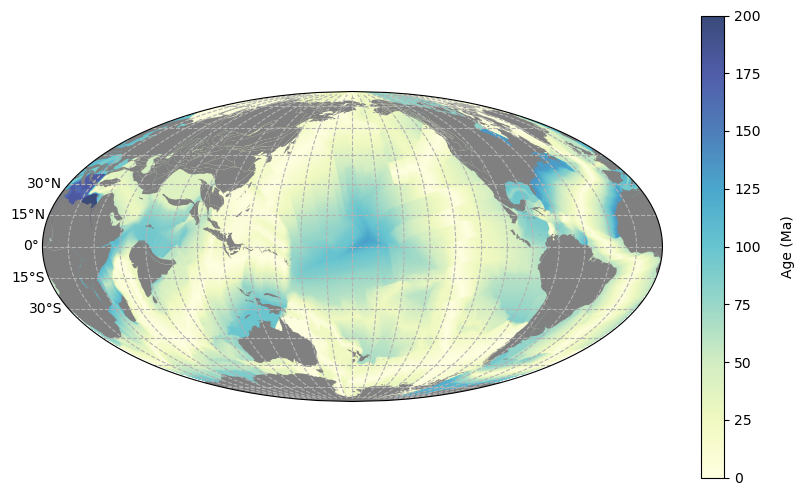

In [32]:
# basic plots

plot_whole_dataset = True
# plot the reconstructed zone
# i_p = None; subducting_pid_p = None; trench_pid_p = None; # plot all
# i_p = 76; subducting_pid_p = None; trench_pid_p = None; # plot one point
i_p = None; subducting_pid_p = 608.0; trench_pid_p = 737.0; # plot one subduction zone by pid lookup

if plot_whole_dataset:

    if i_p is not None:
        mask = np.zeros(len(subduction_data_resampled), dtype=bool)
        mask[i_p] = 1
    elif subducting_pid_p is not None:
        mask = mask_by_pids(subduction_data_resampled, subducting_pid_p, trench_pid_p)
        # print the name of subduction zone
        _name = LookupNameByPid(name_lookups["trench_pids"], name_lookups["trench_names"],\
            int(np.round(trench_pid_p)))
        print(_name)
    else:
        mask = np.ones(len(subduction_data_resampled), dtype=bool)
            

    fig = plt.figure(figsize=(10,6), dpi=100)
    ax = fig.add_subplot(111, projection=ccrs.Mollweide(central_longitude = 180))

    # Plot global features such as coastlines and the age grid using the custom plotting function
    ax = plot_global_basics(ax, gplot, age_grid_raster, reconstruction_time)

    # debug
    # print(subduction_data_resampled['age'])

    # plot all the fixed ages
    # mask = (~subduction_data_resampled['age'].isna())
    
    # plot all points
    ax.scatter(subduction_data_resampled[mask].lon, subduction_data_resampled[mask].lat, marker=".", s=60, c='r', transform=ccrs.PlateCarree())
    # ax.scatter(subduction_data_resampled[~mask].lon, subduction_data_resampled[~mask].lat, marker=".", s=60, c='y', transform=ccrs.PlateCarree())
    ax.scatter(subduction_data_resampled[mask].lon_fix, subduction_data_resampled[mask].lat_fix, marker=".", s=30, c='c', transform=ccrs.PlateCarree())

    # write outputs
    # fileout = os.path.join(RESULT_DIR, "gplate_subduction_zones", "subduction_resampled_t_%.2e_edge_%.2f_section_%.2f.pdf" \
    #                         % (reconstruction_time, arc_length_edge, arc_length_resample_section))
    # fileout1 = os.path.join(RESULT_DIR, "gplate_subduction_zones", "subduction_resampled_t_%.2e_edge_%.2f_section_%.2f.png" \
    #                         % (reconstruction_time, arc_length_edge, arc_length_resample_section))
    # if not (os.path.isdir(os.path.dirname(fileout))):
    #     os.mkdir(os.path.dirname(fileout))
    # fig.savefig(fileout)
    # fig.savefig(fileout1)
    # print("Save figure: %s" % fileout)
    # print("Save figure: %s" % fileout1)

else:
    print("Skip plotting")

##### Select and plot the points based on nearness to a query point

In [33]:
plot_near_points = False
# plot the reconstructed zone
# query longitude, latitude and distance
lat_q = -14.0
lon_q = 165.0
dist_q = 500 # km

n_near_points = 0
point_indexes = []
if plot_near_points:

    mask = np.zeros(len(subduction_data_resampled), dtype=bool)
    for i in range(len(subduction_data_resampled)):
        dist = haversine(lat_q, lon_q, subduction_data_resampled.lat[i], subduction_data_resampled.lon[i], radius=6371)
        if dist < dist_q:
            mask[i] = 1
            n_near_points += 1
            point_indexes.append(i)

    # print the near points, subducting and trench pid, as well as trench name
    subduction_data_resampled_masked = subduction_data_resampled[mask]
    for i in range(n_near_points):
        _name = LookupNameByPid(name_lookups["trench_pids"], name_lookups["trench_names"],\
            int(np.round(subduction_data_resampled_masked.trench_pid[point_indexes[i]])))
        print("point indexes\t", "lat\t\t\t" ,"lon\t\t\t", "subducting_pid\t", "trench_pid\t", "name\t")
        print(point_indexes[i], "\t\t", subduction_data_resampled_masked.lat[point_indexes[i]], "\t",\
              subduction_data_resampled_masked.lon[point_indexes[i]], "\t",\
              subduction_data_resampled_masked.subducting_pid[point_indexes[i]],"\t\t",\
              subduction_data_resampled_masked.trench_pid[point_indexes[i]],"\t\t", _name,"\t")


    fig = plt.figure(figsize=(10,6), dpi=100)
    ax = fig.add_subplot(111, projection=ccrs.Mollweide(central_longitude = 180))

    # Plot global features such as coastlines and the age grid using the custom plotting function
    ax = plot_global_basics(ax, gplot, age_grid_raster, reconstruction_time)

    # # debug
    # print(subduction_data_resampled['age'])

    # # plot all the fixed ages
    # mask = (~subduction_data_resampled['age'].isna())
    
    # plot all points
    ax.scatter(lon_q, lat_q, marker=".", s=200, c='purple', transform=ccrs.PlateCarree(), label="Query point")
    ax.scatter(subduction_data_resampled[mask].lon, subduction_data_resampled[mask].lat, marker=".", s=60, c='r', transform=ccrs.PlateCarree(), label="Near points")
    # ax.scatter(subduction_data_resampled[~mask].lon, subduction_data_resampled[~mask].lat, marker=".", s=60, c='y', transform=ccrs.PlateCarree())
    # ax.scatter(subduction_data_resampled[mask].lon_fix, subduction_data_resampled[mask].lat_fix, marker=".", s=30, c='c', transform=ccrs.PlateCarree())

    # write outputs
    # fileout = os.path.join(RESULT_DIR, "gplate_subduction_zones", "subduction_resampled_t_%.2e_edge_%.2f_section_%.2f.pdf" \
    #                         % (reconstruction_time, arc_length_edge, arc_length_resample_section))
    # fileout1 = os.path.join(RESULT_DIR, "gplate_subduction_zones", "subduction_resampled_t_%.2e_edge_%.2f_section_%.2f.png" \
    #                         % (reconstruction_time, arc_length_edge, arc_length_resample_section))
    # if not (os.path.isdir(os.path.dirname(fileout))):
    #     os.mkdir(os.path.dirname(fileout))
    # fig.savefig(fileout)
    # fig.savefig(fileout1)
    # print("Save figure: %s" % fileout)
    # print("Save figure: %s" % fileout1)

else:
    print("Skip plotting")

Skip plotting


#### Export to a csv file

In [34]:
record_file = False
# export the file to a temp file
if resample_all:
    temp_file = os.path.join(ASPECT_LAB_DIR, "dtemp", "gplate_export_test0", "subduction_resampled_t_%.2e_edge_%.2f_section_%.2f.csv" \
                            % (reconstruction_time, arc_length_edge, arc_length_resample_section))
else:
    temp_file = os.path.join(ASPECT_LAB_DIR, "dtemp", "gplate_export_test0", "subduction_resampled_t_%.2e_pid_%d_edge_%.2f_section_%.2f.csv" \
                         % (reconstruction_time, int(trench_pid), arc_length_edge, arc_length_resample_section))

# don't mess up the existing files
if record_file:
    if use_recorded_file:
        # in case we read from an existing file, omit the index when output
        subduction_data_resampled.to_csv(temp_file, index=False)
    else:
        subduction_data_resampled.to_csv(temp_file)

    print("Data saved to %s" % temp_file)

### Analyze extracted data set

We plot:

* age vs convergence / trench retreat rate of trenches below.
* trench distance vs convergence / trench retreat rate of trenches below.

#### Some notes

##### On the Proccedure

- Filtering short slab using the "deep_slab" vector would vary the result quite a bit.

##### On specific subduction zones

* TON-KERM: by calculating the distance, points are matched to the other side of north Fiji Basin, resulting in small distance value.
* Ryuku: data is missing in the current dataset, fixing using values form Table 1 in Lallemend et al., 2005
* JAVA: One single point has an advance motion.
* LUZ: gplately data suggest advance of 2.5, while L05 shows fast retreat motion. When computing the distance, the LUZ will be matched to the east LUZ and result in very small values
* KuKam: data shows retreat motion, while L05 shows advance motion
* PER-NCHI-JUAN-SCHI (subduction id 911): These seem to be all in the subduction id 901. Beyond a trench id of 201, the trench id varies from 201010 to 20101?. Up north, the component is marked with trench id 2031 (Caribbean/farallon subduction iniating at 85 Ma).
* South to SCHI: This is represented by the subduction id 801, but the trench id 201 continues from the previous 901 subduction.
* ANT: retreat motion in this dataset, rather than the advance motion in L05

#### Calculate a distance to an adjacent subduction zone

**Find Nearest Deep Subduction Points**:
   - For each subduction point, iterates over all other points in the dataset.
   - Filters out shallow subduction points and those within the same subduction zone.
   - Calculates the distance and bearing angle to each other point, checking if it falls within the specified angle tolerance (`theta_diff`).
   - Updates the minimum distance if a closer deep subduction point is found within the angle tolerance (initialized as the length of the Earth's equator).

In [35]:
from pyproj import Geod

# Define Earth's radius in meters
Ro = 6371e3

# Initialize the Geod object with the WGS84 ellipsoid model, 
# which provides accurate geodesic calculations on Earth's surface
geod = Geod(ellps="WGS84")

# Initialize arrays to store distances, indexes, and markers for subduction data points
subduction_distances = np.zeros(len(subduction_data_resampled))  # Stores the minimum distance for each subduction point
subduction_indexes = np.array(range(len(subduction_data_resampled)))  # Indexes for each point in the dataset
subduction_min_distance_indexes = np.full(len(subduction_data_resampled), -1, dtype=int)  # Indexes of the closest deep subduction point
subduction_maker_lons = []  # Stores longitudes of marker points
subduction_maker_lats = []  # Stores latitudes of marker points

# Define the default comparison distance as Earth's circumference
# and set parameters for marker distance and angle tolerance
d_m = 1000e3  # Distance of the marker point in meters
theta_diff = 45.0  # Tolerance angle in degrees for direction comparison

# Iterate over each subduction point in the resampled data to compute closest distances
for i_1 in range(len(subduction_data_resampled)):
    subducting_pid_1 = int(subduction_data_resampled.subducting_pid[i_1])
    lat1, lon1 = subduction_data_resampled.lat[i_1], subduction_data_resampled.lon[i_1]

    # Place a marker point at a distance `d_m` along the trench normal angle (`theta`)
    theta = subduction_data_resampled.trench_azimuth_angle[i_1]
    theta = (theta + 360) % 360  # Normalize angle `theta` to the range [0, 360)
    lon_m, lat_m = Utilities.map_point_by_distance(lon1, lat1, theta, d_m)

    # Get the path coordinates between the original point and marker point
    path_lon_m, path_lat_m = Utilities.shortest_path_between_two_points([lon1, lat1], [lon_m, lat_m], geod.npts, 100)
    subduction_maker_lons.append(path_lon_m)
    subduction_maker_lats.append(path_lat_m)

    # Set initial comparison distance to Earth's circumference
    distance = 2 * np.pi * Ro

    # Find the closest deep subduction point with matching angle tolerance
    for j_2 in range(len(subduction_data_resampled)):
        subducting_pid_2 = int(subduction_data_resampled.subducting_pid[j_2])

        # Skip shallow slabs (< 410 km depth)
        if not subduction_data_resampled.deep_slab[j_2]:
            continue
        
        # Skip points on the same subduction zone (including itself)
        if subducting_pid_1 == subducting_pid_2:
            continue
        
        # Calculate the distance and bearing to the other point
        lat2, lon2 = subduction_data_resampled.lat[j_2], subduction_data_resampled.lon[j_2]
        theta_1 = Utilities.calculate_bearing(lon1, lat1, lon2, lat2)  # Bearing angle to the other point
        distance_between_points = haversine(lat1, lon1, lat2, lon2)
        
        # Update distance if closer point is found within the angle tolerance
        if distance_between_points < distance and abs(theta_1 - theta) < theta_diff:
            distance = distance_between_points
            subduction_min_distance_indexes[i_1] = j_2
    
    # Store the computed minimum distance for the current point
    subduction_distances[i_1] = distance

# Add the computed distances to the DataFrame as a new column
subduction_data_resampled["near_distance"] = subduction_distances


#### Visualize the matching points of minimum distance

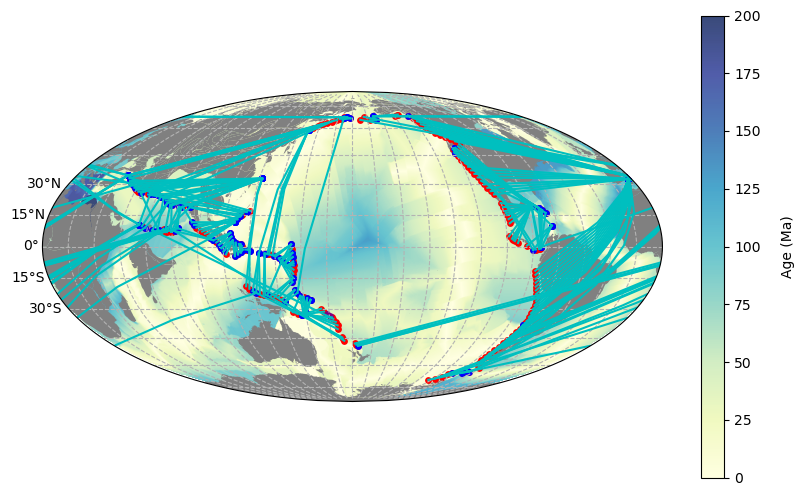

In [38]:
# Define plotting parameters to specify which subduction zone or point to display
i_p = None; subducting_pid = None; trench_pid=None # Uncomment to plot one subduction zone
# i_p = 43; subducting_pid = None; trench_pid=None # Uncomment to plot one point
# i_p = None; subducting_pid = 801; trench_pid = None  # Plot specific subduction zone with subducting plate ID

# Initialize the figure and axis with a Mollweide projection for global plotting
fig = plt.figure(figsize=(10, 6), dpi=100)
ax = fig.add_subplot(111, projection=ccrs.Mollweide(central_longitude=180))

# Plot the global coastline, age grid, and other basic features on the map
plot_global_basics(ax, gplot, age_grid_raster, reconstruction_time)

# Create masks to filter subduction points based on specified parameters
mask1 = MaskBySubductionTrenchIds(subduction_data_resampled, subducting_pid, trench_pid, i_p)  # Filter by IDs
mask2 = (subduction_min_distance_indexes >= 0)  # Filter points with valid trench distances

# Combine masks to get points with and without valid trench distances
mask = mask1 & mask2  # Valid points with trench distance
mask_in = mask1 & (~mask2)  # Invalid points without trench distance

# Separate valid and invalid indexes for plotting
min_indexes_invalid = subduction_min_distance_indexes[mask_in]
min_indexes_valid = subduction_min_distance_indexes[mask]
indexes_valid = subduction_indexes[mask]

# Plot pairs of matching points in the subduction zones
# This includes plotting each marker path along the convergence direction and distance `d_m`
ax.scatter(subduction_data_resampled.lon[mask], subduction_data_resampled.lat[mask], 
           marker=".", s=60, c='r', transform=ccrs.PlateCarree())  # Plot valid points in red
ax.scatter(subduction_data_resampled.lon[mask_in], subduction_data_resampled.lat[mask_in], 
           marker=".", s=60, c='purple', transform=ccrs.PlateCarree())  # Plot invalid points in purple

# Loop through each valid pair of points to plot their matching markers and connection lines
for i in range(len(min_indexes_valid)):
    try:
        # Plot the matching points in blue
        ax.scatter(subduction_data_resampled.lon[min_indexes_valid[i]], 
                   subduction_data_resampled.lat[min_indexes_valid[i]], 
                   marker=".", s=60, c='b', transform=ccrs.PlateCarree())
        
        # Draw a line between each query point and its matching subduction point
        ax.plot([subduction_data_resampled.lon[indexes_valid[i]], subduction_data_resampled.lon[min_indexes_valid[i]]],
                [subduction_data_resampled.lat[indexes_valid[i]], subduction_data_resampled.lat[min_indexes_valid[i]]],
                c='c', transform=ccrs.PlateCarree())  # Plot lines in cyan
    except KeyError:
        pass  # Skip plotting if an index is missing (for debugging purposes)


#### Plot results of analysis

[101.0, 201.0, 304.0, 501.0, 529.0, 608.0, 609.0, 633.0, 701.0, 780.0, 781.0, 801.0, 802.0, 804.0, 836.0, 901.0, 902.0, 904.0, 908.0, 918.0, 926.0, 7763.0, 18409.0, 53401.0]
Id 101 not found, marked as TBD
0 , subducting_id =  101.0 , trench_pid =  None
1 , subducting_id =  201.0 , trench_pid =  2011
2 , subducting_id =  201.0 , trench_pid =  815
Id 304 not found, marked as TBD
3 , subducting_id =  304.0 , trench_pid =  None
Id 501 not found, marked as TBD
4 , subducting_id =  501.0 , trench_pid =  None
Id 529 not found, marked as TBD
5 , subducting_id =  529.0 , trench_pid =  None
6 , subducting_id =  608.0 , trench_pid =  None
Id 609 not found, marked as TBD
7 , subducting_id =  609.0 , trench_pid =  None
Id 633 not found, marked as TBD
8 , subducting_id =  633.0 , trench_pid =  None
Id 701 not found, marked as TBD
9 , subducting_id =  701.0 , trench_pid =  None
Id 780 not found, marked as TBD
10 , subducting_id =  780.0 , trench_pid =  None
Id 781 not found, marked as TBD
11 , subdu

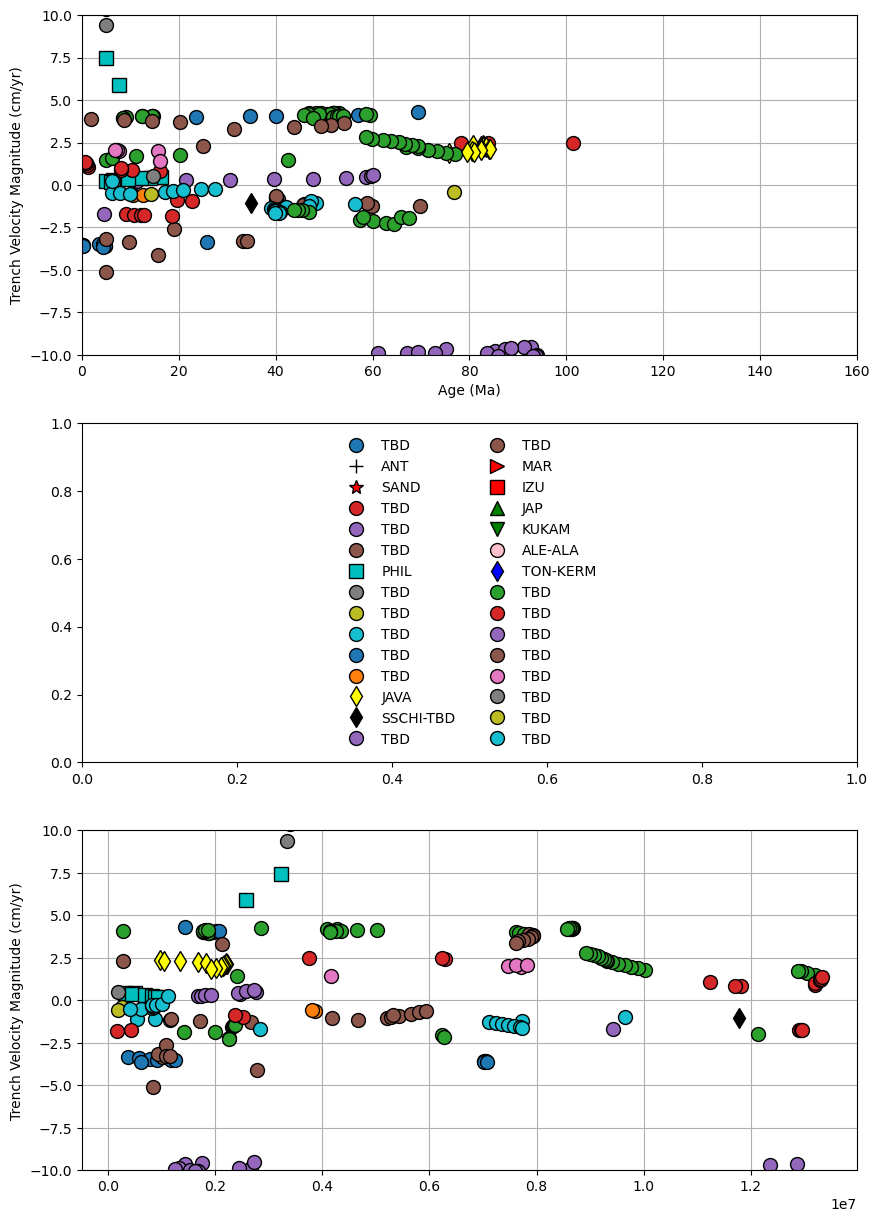

In [37]:
# The dictionary keys represent subduction zone IDs, and the values specify

from matplotlib.path import Path
# the marker style, face color, and name associated with that ID.
# this definition of snowflake initially has an error in the "code" part
verts = [
    (0., 0.),   # Center
    (0.2, 0.6), # Upper arm
    (0., 0.),   # Center
    (0.4, 0.4), # Right diagonal
    (0., 0.),   # Center
    (0.6, 0.2), # Right arm
    (0., 0.),   # Center
    (0.4, -0.4),# Right down diagonal
    (0., 0.),   # Center
    (0.2, -0.6),# Bottom arm
    (0., 0.),   # Center
    (-0.4, -0.4),# Left down diagonal
    (0., 0.),   # Center
    (-0.6, -0.2),# Left arm
    (0., 0.),   # Center
    (-0.4, 0.4),# Left diagonal
    (0., 0.),   # Center
    (-0.2, 0.6),# Upper left arm
]
codes = [Path.MOVETO] + [Path.LINETO, Path.MOVETO] * 8 + [Path.MOVETO]
snowflake = Path(verts, codes)

# Define vertices for two equilateral triangles
vertices = [
    [0, 1], [-np.sqrt(3)/2, -0.5], [np.sqrt(3)/2, -0.5], [0, 1],  # First triangle
    [0, -1], [-np.sqrt(3)/2, 0.5], [np.sqrt(3)/2, 0.5], [0, -1]   # Second triangle
]
# Flatten the vertices list for creating the Path
vertices = np.array(vertices)
# Define path codes (all 'LINETO' except the start 'MOVETO')
codes = [Path.MOVETO] + [Path.LINETO] * (len(vertices) - 1)

star_path = Path(vertices, codes)

plot_options = \
{
    903: {"marker": 'o',  "markerfacecolor": "yellow", "name": "CAS"},
    511: {"marker": 's',  "markerfacecolor": "yellow", "name": "ANDA-SUM"},
    801: {"marker": 'd',  "markerfacecolor": "yellow", "name": "JAVA"},
    645: {"marker": snowflake,  "markerfacecolor": "black", "name": "SULA"},
    602: {"marker": 'x',  "markerfacecolor": "blue", "name": "LUZ"},
    608: {"marker": 's',  "markerfacecolor": 'c', "name": "PHIL"},
    901: {
        699: {"marker": '>',  "markerfacecolor": 'red', "name": "MAR"},
        659: {"marker": 's',  "markerfacecolor": 'red', "name": "IZU"},
        (601112.0, 601118.0): {"marker": '^',  "markerfacecolor": 'green', "name": "JAP"},
        406:{"marker": 'v',  "markerfacecolor": 'green', "name": "KUKAM"},
        111: {"marker": 'o',  "markerfacecolor": 'pink', "name": "ALE-ALA"},
        (806, 821): {"marker": 'd',  "markerfacecolor": 'blue', "name": "TON-KERM"}
        },
    909: {"marker": star_path,  "markerfacecolor": 'c', "name": "MEX"},
    911: {"marker": 'o',  "markerfacecolor": 'k', "name": "PER-NCHI-JUAN-SCHI"},
    802: {"marker": 'd',  "markerfacecolor": 'k', "name": "SSCHI-TBD"},
    201: {
        2011:{"marker": '+',  "markerfacecolor": 'pink', "name": "ANT"},
        815:{"marker": '*',  "markerfacecolor": 'r', "name": "SAND"}
        },
    1: {"marker": 'd',  "markerfacecolor": "r", "name": "RYU"}
}

# Create a figure and two subplots for plotting trench velocity data.
# `gs` defines a 2x1 grid layout for the subplots.
fig = plt.figure(figsize=(10, 15))
gs = gridspec.GridSpec(3, 1)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[2, 0])
total_points_plotted = 0  # Variable to record the total number of plotted points.

# Filter out rows with NaN values in the "age" column.
mask_age = (~subduction_data_resampled["age"].isna())
total_points_plotted += len(subduction_data_resampled[mask_age])  # Count valid points.
subduction_data_resampled_valid = subduction_data_resampled[mask_age]  # Store valid data.

# Obtain a sorted list of unique subducting plate IDs from the valid data.
# and round to nearest integar value
unique_subducting_pids_0 = subduction_data_resampled_valid.subducting_pid.unique()

unique_subducting_pids = []
seen = set()
for val in unique_subducting_pids_0:
    if abs(val - round(val) < 0.1) and round(val) not in seen:
           unique_subducting_pids.append(float(round(val)))
           seen.add(round(val))
    
labels = []
patches = []
unique_subducting_pids.sort()  # Sort the unique subducting plate IDs.
print(unique_subducting_pids)

# Lookup and store subducting plate names based on their IDs.
unique_subducting_names = []
for i in range(len(unique_subducting_pids)):
    subducting_pid = unique_subducting_pids[i]
    # unique_subducting_names.append(GParseReconstruction.LookupNameByPid(int(subducting_id)))
    unique_subducting_names.append(LookupNameByPid(trench_pids, name_lookups["trench_names"], int(subducting_pid)))

# Loop through each subducting plate ID and plot the corresponding trench velocity.
k = 0
for i in range(len(unique_subducting_pids)):
    _name = unique_subducting_names[i]

    subducting_id = unique_subducting_pids[i]
    try:
        plot_option_sub_dict = plot_options[int(subducting_id)]  # Get plot options for the ID.
    except KeyError:
        # If no specific plot option is found, use default settings.
        # continue # comment this to plot as TBD points
        print("Id %s not found, marked as TBD" % int(subducting_id))
        plot_option_sub_dict = {"marker": 'o',  "markerfacecolor": None, "name": "TBD"}

    # Make an output for the plotting function to loop over the trench ids
    plot_trench_pids = None; plot_option_list = None
    if 'name' in plot_option_sub_dict:
        # A subduction contains a single trench
        plot_trench_pids = [None]
        plot_option_list = [plot_option_sub_dict.copy()]
    else:
        # A subduction contains multiple trenches
        plot_trench_pids = []
        plot_option_list = []
        for key, value in plot_option_sub_dict.items():
            plot_trench_pids.append(key)
            plot_option_list.append(value.copy())

    # Loop over the trench ids and plot the markers
    for i_tr in range(len(plot_trench_pids)):
        trench_pid = plot_trench_pids[i_tr]
        plot_option = plot_option_list[i_tr]
        # We want trench_pid options to be flexible.
        # It could be a - a value; b - a range and c - multiple values
        # d - None
        # Create a mask for the current subducting plate and plot its trench velocity.
        # We allow a variation of 0.1 from the integar value
        # mask1 - match the subducting id
        # mask2 - match the trench pid condition.
        mask1 = (abs(subduction_data_resampled.subducting_pid - subducting_id) < 0.1)
        if trench_pid is None:
            mask = mask1
        elif type(trench_pid) == float or type(trench_pid) == int:
            mask = mask1 & (abs(subduction_data_resampled.trench_pid - trench_pid) < 0.1)
        elif type(trench_pid) == list:
            # mutiple values
            mask2 = (abs(subduction_data_resampled.trench_pid - trench_pid[0]) < 0.1)
            for trench_sub_pid in trench_pid[1:]:
                mask2 = mask2 | (abs(subduction_data_resampled.trench_pid - trench_sub_pid) < 0.1)
            mask = mask1 & mask2
        elif type(trench_pid) == tuple:
            # a range
            assert(len(trench_pid) == 2)
            mask2 = ((subduction_data_resampled.trench_pid >= trench_pid[0]) & (subduction_data_resampled.trench_pid <= trench_pid[1]))
            mask = mask1 & mask2
        else:
            raise ValueError("Type of trench pid is wrong. Possible types are [None, float, int, list, dict]")
        ages = subduction_data_resampled_valid.age[mask]
        trench_velocities = subduction_data_resampled_valid.trench_velocity[mask]
        near_distances = subduction_data_resampled_valid.near_distance[mask]
        _patch = ax1.plot(ages, trench_velocities,\
                marker=plot_option["marker"], markerfacecolor=plot_option["markerfacecolor"],\
                markeredgecolor='black', markersize=10, linestyle='', label=plot_option["name"])[0]
        _patch_d = ax3.plot(near_distances, trench_velocities,\
                marker=plot_option["marker"], markerfacecolor=plot_option["markerfacecolor"],\
                markeredgecolor='black', markersize=10, linestyle='', label=plot_option["name"])[0]
        patches.append(_patch)
        print(k, ", subducting_id = ", subducting_id, ", trench_pid = ", trench_pid)
        k += 1

# Configure grid and legend for the second subplot.
ax1.grid()
ax3.grid()
ax2.legend(handles=patches, bbox_to_anchor=(0.5, 0.5), loc='center', ncol=2, numpoints=1, frameon=False)

# Output the total number of plotted points.
print("Total plotted points: %d" % total_points_plotted)

# Set axis limits and labels for the first plot (trench velocity vs age).
ax1.set_xlim([0, 160.0])
ax1.set_ylim([-10.0, 10.0])
ax3.set_ylim([-10.0, 10.0])
ax1.set_xlabel("Age (Ma)")
ax1.set_ylabel("Trench Velocity Magnitude (cm/yr)")
ax3.set_ylabel("Trench Velocity Magnitude (cm/yr)")

# Save the figure to a PDF file with a name derived from the reconstruction parameters.
fileout = os.path.join(RESULT_DIR, "gplate_subduction_zones", "subduction_distribution_t_%.2e_edge_%.2f_section_%.2f.pdf"\
     % (reconstruction_time, arc_length_edge, arc_length_resample_section))
fig.savefig(fileout)
print("figure saved: %s" % fileout)

# Save the subducting plate ID and names to a CSV file for future reference.
csv_out = os.path.join(RESULT_DIR, "gplate_subduction_zones", "subduction_distribution_t_%.2e_edge_%.2f_section_%.2f.csv"\
     % (reconstruction_time, arc_length_edge, arc_length_resample_section))
unique_data = {
    "pid": unique_subducting_pids,
    'name': unique_subducting_names
}
df_unique_data = pd.DataFrame(unique_data)
df_unique_data.to_csv(csv_out)
print("csv file saved: %s" % csv_out)